In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
#import Configuration
#from importlib import reload
#reload(Configuration)
#from Configuration import ITERATIONS, NUMBER_OF_PRICES, MIN_PRICE, MAX_PRICE, PRICES, COST, DAYS, INTERVAL_LENGTH

In [3]:
#DA ELIMINARE
# Configuration parameters
ITERATIONS = 50
AUCTIONS = 10 # auctions per day
BUDGET_PER_AUCTION = 0.5
BUDGET_PER_DAY = BUDGET_PER_AUCTION * AUCTIONS
N_USERS = 1000
N_ADVERTISERS = 10    # number of companies that compete for slot auctions, including myself
NUMBER_OF_ARMS = 100    # needed for the UCB algorithm
MIN_PRICE = 0
MAX_PRICE = 1
COST = 0.1
NUMBER_OF_PRICES = 10
PRICES = np.linspace(MIN_PRICE, MAX_PRICE, NUMBER_OF_PRICES)
BUDGET = 500
NUMBER_OF_SLOTS = 10

lambda_fun_param = lambda s: 1/(s+(0.3))       # probability of the ad being seen given the position s ->  0.5 for first position, 0.33 for second, 0.25 for third, etc...
LAMBDAS = np.array([lambda_fun_param(i) for i in range(1, NUMBER_OF_SLOTS+1)])    # array of lambda values (for each slot)

DAYS = 1000 # number of rounds of the pricing algorithm
INTERVAL_LENGTH = 10 # length of the interval (in days) for changing the demand curve

In [4]:
min_price = MIN_PRICE
max_price = MAX_PRICE
number_of_prices = NUMBER_OF_PRICES # length of the prices vector
prices = PRICES
cost = COST
days = DAYS
interval_length = 5*INTERVAL_LENGTH

conversion_probability_no_noise = lambda p,d: 1 - np.exp(p/max_price - 1)/2 - changing_x(d, noise=False)  # expected demand curve in terms of probability of purchase
conversion_probability = lambda p,d: 1 - np.exp(p/max_price - 1)/2 - changing_x(d, noise=True)  # expected demand curve in terms of probability of purchase

#we compute the maximum noise interval in order to prevent the conversion probability to go outside the [0,1] interval
min_possible_price = cost

max_probability_fixed_part = 1 - np.exp(min_possible_price/max_price - 1)/2
print("max_probability_fixed_part", max_probability_fixed_part)
min_variable_part = -(1 - max_probability_fixed_part)
print("min_variable_part", min_variable_part)

def changing_x(d, noise):
    # we change value of x every 'interval_length' days
    t = d // interval_length # integer division

    t -= np.pi # just to make it start at 0

    x = np.sin(t)
    if noise:
        x -= np.random.uniform(0, 0.5)
    return (x+1)/4 # bounded between 0 and 0.5 (except for noise, but resulting probability is still between 0 and 1)





max_probability_fixed_part 0.7967151701297004
min_variable_part -0.2032848298702996


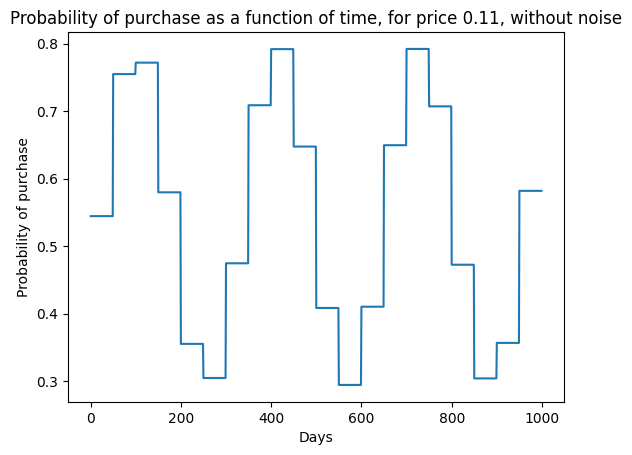

Text(0, 0.5, 'Probability of purchase')

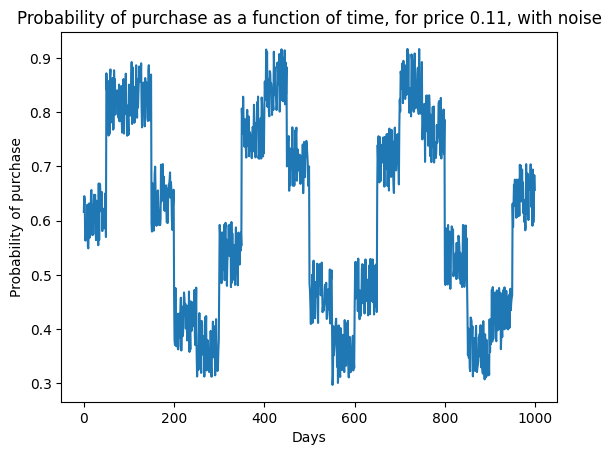

In [9]:
T = 1000
W=math.sqrt(T)
t_interval = range(T)
price = prices[1]
probabilities = [conversion_probability_no_noise(price, t) for t in t_interval]
plt.plot(t_interval, probabilities)
plt.title('Probability of purchase as a function of time, for price %.2f, without noise' % price)
plt.xlabel('Days')
plt.ylabel('Probability of purchase')
plt.show()
probabilities = [conversion_probability(price, t) for t in t_interval]
plt.plot(t_interval, probabilities)
plt.title('Probability of purchase as a function of time, for price %.2f, with noise' % price)
plt.xlabel('Days')
plt.ylabel('Probability of purchase')

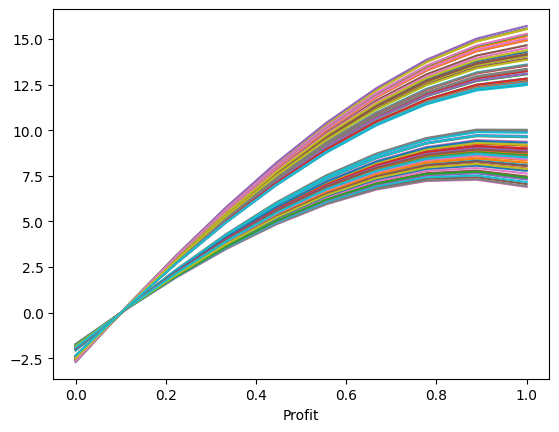

In [11]:
# let's plot the profit curves for different times
t_interval = range(0, 100)
n_users = 30 # just an example

for t in t_interval:
    expected_profit_curve = n_users*conversion_probability(prices, t)*(prices-cost)
    plt.plot(prices, expected_profit_curve)

plt.xlabel('Profit')
plt.show()

# Definition of the environment + mu + the baseline

In [12]:
## definition of the NonstationaryBernoulliEnvironment
class NonstationaryBernoulliEnvironment:
    def __init__(self, mu, T, seed, prices, cost):
        np.random.seed(seed)
        self.mu = np.array(mu)
        self.prices = prices # possible arms
        self.cost = cost
        print(f"mu.shape: {self.mu.shape}")  # Debug print
        self.rewards = np.random.binomial(n=1, p=self.mu)  # binomial variable (0 or 1) with probability of success mu
        print(f"rewards.shape: {self.rewards.shape}")  # Debug print
        self.K = self.rewards.shape[1] # number of arms, number of columns of mu
        self.t = 0

    def round(self, a_t):
        if self.t >= self.rewards.shape[0]:
            raise IndexError(f"IndexError: self.t ({self.t}) is out of bounds for rewards with shape {self.rewards.shape}")
        #print(f"self.t: {self.t}, a_t: {a_t}, rewards.shape: {self.rewards.shape}")  # Debug print
        r_t = self.rewards[self.t, a_t] # generate the reward of a_t
        profit_t = r_t * (self.prices[a_t] - self.cost)
        self.t += 1
        return r_t, profit_t



## definition of mu
#number of prices = number of arms
#mu is a matrix with T rows (one row for each turn) and k columns (one for each arm/price) that contains the conversion probability of each arm at each turn
#conversion_probability is a function that generates a conversion probability for a given price and time
#in this case, we used the function with noise for the conversion probability
mu = np.zeros((T, number_of_prices))
for t in range(T):
    for k in range(number_of_prices):
        price = PRICES[k]
        mu[t, k] = conversion_probability(price, t)





env = NonstationaryBernoulliEnvironment(mu, T, seed=17, prices=prices, cost=COST)
y = env.rewards
## Definition of the baseline (clairvoyant) based on the profit
# create the natrix witth expected_profits for each day for each arm
expected_profits = mu * (prices - COST)
# compute the expected_clairvoyant_profits
expected_clairvoyant_profits = np.max(expected_profits, axis=1)



# TO COMPUTE THE BEST PRICE FOR THE GRAPH
reward_function = lambda price, n_sales: (price - COST) * n_sales
profit_curve = lambda t: reward_function(prices, N_USERS * conversion_probability(prices, t))
rewards = np.array([profit_curve(t) for t in range(T)])
total_rewards = np.sum(rewards, axis=0)
best_price_index = np.argmax(total_rewards)
best_price = PRICES[best_price_index]




mu.shape: (1000, 10)
rewards.shape: (1000, 10)


# Creating the sliding window UCB agent

In [13]:
class SWUCBAgent:
    def __init__(self, K, T, W, range=1):
        self.K = K
        self.T = T
        self.W = W
        self.range = range
        self.a_t = None
        self.cache = np.repeat(np.nan, repeats=K*W).reshape(W, K) # matrice WxK che memorizza le ricompense passate
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t #with this if I make sure that each arm is played at least once
        else:
            n_pulls_last_w = self.W - np.isnan(self.cache).sum(axis=0) # count how many times each arm has been played in the last W rounds
            avg_last_w = np.nanmean(self.cache, axis=0) # compute the average reward of each turn in the last W rounds
            ucbs = avg_last_w + self.range*np.sqrt(2*np.log(self.W)/n_pulls_last_w) # compute the UCB for each arm, there's a typo in the slides, log(T) -> log(W)
            self.a_t = np.argmax(ucbs) # choose the arm with the highest UCB
        #print(f"SWUCBAgent: Day {self.t}, Pulling arm {self.a_t}")  # Debugging print
        return self.a_t # return the chosen arm

    def update(self, profit_t):
        self.N_pulls[self.a_t] += 1 # update the count of the number of times I chose the arm a_t
        self.cache = np.delete(self.cache, (0), axis=0) # remove oldest observation from W
        new_samples = np.repeat(np.nan, self.K) # creates a new empty array with a slot for each arm
        new_samples[self.a_t] = profit_t # in the position related to the chosen arm a_t put its reward
        self.cache = np.vstack((self.cache, new_samples)) # add new observation in the window W
        self.t += 1 # increase the number of round
        #print(f"SWUCBAgent: Day {self.t}, Updated arm {self.a_t} with reward {r_t}")  # Debugging print

# assuming U_T is known
# W = int(2*np.sqrt(np.log(T))) # if U_T is unknown (i.e., set U_T=T)

## Simulation for sliding window UCB

In [15]:
## we try a first itaration with T=1000
T = 1000
W = int(np.sqrt(t))

n_trials = 10

regret_per_trial = []
pulls_per_trial = np.zeros((n_trials, number_of_prices))

for seed in range(n_trials):
    np.random.seed(seed)
    env = NonstationaryBernoulliEnvironment(mu, T, seed, prices=prices, cost=COST)
    ucb_agent = SWUCBAgent(number_of_prices, T, W)

    agent_rewards = np.array([])

    for t in range(T):
        a_t = ucb_agent.pull_arm()
        #print(f"a_t: {a_t}, number_of_prices: {number_of_prices}")  # Debug print
        if a_t >= number_of_prices:
            print(f"Error: a_t ({a_t}) is out of bounds!")  # Additional check
            break
        try:
            r_t, profit_t = env.round(a_t)
        except IndexError as e:
            print(e)
            break
        ucb_agent.update(profit_t)

        agent_rewards = np.append(agent_rewards, profit_t)
        print(f"Trial {seed}, Day {t}, SW-UCB: Pulled arm {a_t}, Received reward {r_t}, Profit {profit_t}")  # Debugging print

    #print(f"agent_rewards.shape: {agent_rewards.shape}")  # Debug print
    cumulative_regret = np.cumsum(expected_clairvoyant_profits - agent_rewards)
    regret_per_trial.append(cumulative_regret)

    pulls_per_trial[seed] = ucb_agent.N_pulls

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)
average_pulls = pulls_per_trial.mean(axis=0)

Output streaming troncato alle ultime 5000 righe.
Trial 5, Day 8, SW-UCB: Pulled arm 8, Received reward 0, Profit 0.0
Trial 5, Day 9, SW-UCB: Pulled arm 9, Received reward 0, Profit 0.0
Trial 5, Day 10, SW-UCB: Pulled arm 4, Received reward 1, Profit 0.34444444444444444
Trial 5, Day 11, SW-UCB: Pulled arm 3, Received reward 1, Profit 0.2333333333333333
Trial 5, Day 12, SW-UCB: Pulled arm 2, Received reward 0, Profit 0.0
Trial 5, Day 13, SW-UCB: Pulled arm 1, Received reward 1, Profit 0.0111111111111111
Trial 5, Day 14, SW-UCB: Pulled arm 5, Received reward 0, Profit 0.0
Trial 5, Day 15, SW-UCB: Pulled arm 6, Received reward 0, Profit 0.0
Trial 5, Day 16, SW-UCB: Pulled arm 7, Received reward 0, Profit 0.0
Trial 5, Day 17, SW-UCB: Pulled arm 8, Received reward 0, Profit 0.0
Trial 5, Day 18, SW-UCB: Pulled arm 9, Received reward 0, Profit 0.0
Trial 5, Day 19, SW-UCB: Pulled arm 0, Received reward 0, Profit -0.0
Trial 5, Day 20, SW-UCB: Pulled arm 4, Received reward 1, Profit 0.3444444444

We defined a sliding window equal to:
 $$ W = \sqrt{T} $$
As suggested during the lab

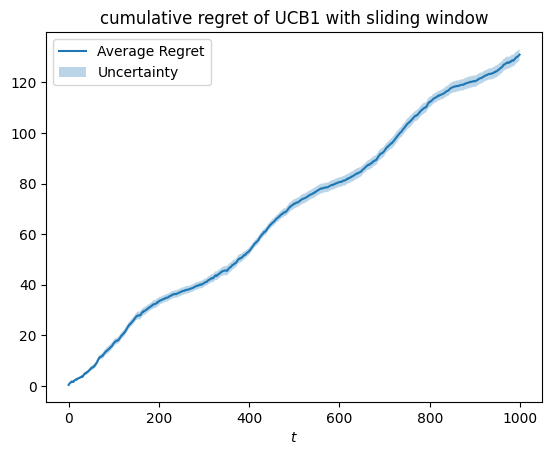

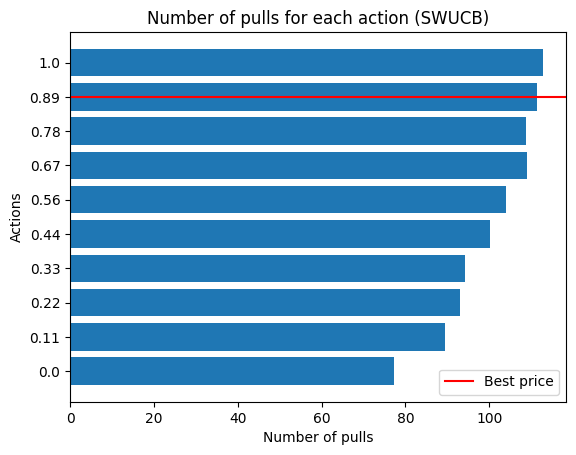

In [17]:
plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1 with sliding window')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

# number of pulls for each arm
plt.figure()
plt.barh(np.arange(number_of_prices), average_pulls, align='center')
plt.axhline(best_price_index, color='red', label='Best price')
plt.yticks(np.arange(number_of_prices), [round(prices[i], 2) for i in range(number_of_prices)])
plt.xlabel('Number of pulls')
plt.ylabel('Actions')
plt.title('Number of pulls for each action (SWUCB)')
plt.legend()
plt.show()

The regret we obtain is not sublinear but it was an expected result for this type of algorithm in NSE. However we can observe waves in the regret graph due to the changing demand, every time it changes a new exploraton starts.

# CUSUM-UCB agent

In [19]:
class CUSUMUCBAgent:
    def __init__(self, K, T, M, h, alpha, range=1):
        self.K = K
        self.T = T
        self.M = M # window to detect changes, if the arm has been chosen less times than M don't check the changes
        self.h = h # treshold to detect changes
        self.alpha = alpha # probability of choosing the arm based on UCB
        self.range = range # to know when to stop the exploration phase
        self.a_t = None # chosen arm at time t
        self.reset_times = np.zeros(K) # array to save the reset time of each arm
        self.N_pulls = np.zeros(K) # array that contains the number of time each arm has been chosen
        self.all_rewards = [[] for _ in np.arange(K)] # contains the rewards of each arm
        self.counters = np.repeat(M, K) # array that counts, for each arm, the number of selection before checking the changes (starts from M and decrease every time the arm is chosen)
        self.average_rewards = np.zeros(K) # array that contains the average reward of each arm
        self.n_resets = np.zeros(K) # array that contains the number of resets for each arm
        self.n_t = 0
        self.t = 0

    def pull_arm(self):
        if (self.counters > 0).any(): # if one value inside the counters is >0 means that there is an arm that hasn't been played yet
            for a in np.arange(self.K):
                if self.counters[a] > 0:
                    self.counters[a] -= 1
                    self.a_t = a
                    break
        else: # if all the counters are 0 choose randomly based on the probability alpha
            if np.random.random() <= 1-self.alpha:
                ucbs = self.average_rewards + self.range*np.sqrt(np.log(self.n_t)/self.N_pulls)
                self.a_t = np.argmax(ucbs)
            else: # this is for having more exploration
                self.a_t = np.random.choice(np.arange(self.K)) # extra exploration
        #print(f"CUSUMUCBAgent: Day {self.t}, Pulling arm {self.a_t}")  # Debugging print


        return self.a_t

    def update(self, profit_t):
        self.N_pulls[self.a_t] += 1 # increase the number of selection for a_t
        self.all_rewards[self.a_t].append(profit_t) # add the received reward to the list of all the rewards
        if self.counters[self.a_t] == 0: # if the counter of the chosen arm is 0 than check the change detection
            if self.change_detection(): # if a change is detected make the reset
                self.n_resets[self.a_t] +=1 # increase the number of reset
                self.N_pulls[self.a_t] = 0 # put the number of selection for a_t back to 0
                self.average_rewards[self.a_t] = 0 # same for the rewards
                self.counters[self.a_t] = self.M # set the counter to the detect window
                self.all_rewards[self.a_t] = [] # reset also the rewards
                self.reset_times[self.a_t] = self.t # save the round where the reset is made
                #print(f"CUSUMUCBAgent: Day {self.t}, Reset arm {self.a_t} due to change detection")  # Debugging print
            else: # if no change is detected
                self.average_rewards[self.a_t] += (profit_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t] # update the avg reward for the chosen arm
        self.n_t = sum(self.N_pulls) # update the counter of selections
        self.t += 1 # update the time
        #print(f"CUSUMUCBAgent: Day {self.t}, Updated arm {self.a_t} with reward {r_t}")  # Debugging print


    def change_detection(self):
        ''' CUSUM CD sub-routine. This function returns 1 if there's evidence that the last pulled arm has its average reward changed '''
        u_0 = np.mean(self.all_rewards[self.a_t][:self.M]) # compute the avg of the rewards of the first M moves for each arm
        sp, sm = (np.array(self.all_rewards[self.a_t][self.M:])- u_0, u_0 - np.array(self.all_rewards[self.a_t][self.M:])) # compute the deviations of the avg
        gp, gm = 0, 0 # initialize the counters for comulative deviation changes
        for sp_, sm_ in zip(sp, sm):
            gp, gm = max([0, gp + sp_]), max([0, gm + sm_])
            if max([gp, gm]) >= self.h: # if one of the cumulative counters is more than h return true
                return True
        return False


## Simulation For CUSUM

In [20]:
# arbitrary decision on U_T as U_T = sqrt(number_of_prices)
U_T = np.sqrt(number_of_prices)
h = 2*np.log(T / U_T)  # sensitivity of detection, threshold for cumulative deviation
alpha = np.sqrt(U_T * np.log(T / U_T) / T)  # probability of extra exploration

M = int(np.log(T / U_T))  # robustness of change detection
# M = int(np.sqrt(T)) # usually keep M in [log(T/U_T), sqrt(T/U_T)]


# Calcola il best_price_index
reward_function = lambda price, n_sales: (price - COST) * n_sales
profit_curve = lambda t: reward_function(PRICES, N_USERS * conversion_probability(PRICES, t))
rewards = np.array([profit_curve(t) for t in range(T)])
total_rewards = np.sum(rewards, axis=0)
best_price_index = np.argmax(total_rewards)
best_price = PRICES[best_price_index]

n_trials = 10

regret_per_trial = []
pulls_per_trial_cusum = np.zeros((n_trials, number_of_prices))
resets_per_trial_cusum = np.zeros((n_trials, number_of_prices))


for seed in range(n_trials):
    np.random.seed(seed)
    env = NonstationaryBernoulliEnvironment(mu, T, seed, prices = prices, cost = COST)
    ucb_agent = CUSUMUCBAgent(number_of_prices, T, M, h, alpha)

    agent_rewards = np.array([])

    for t in range(T):
        a_t = ucb_agent.pull_arm()
        r_t, profit_t = env.round(a_t)
        ucb_agent.update(profit_t)

        agent_rewards = np.append(agent_rewards, profit_t)
        print(f"Trial {seed}, Day {t}, CUSUM-UCB: Pulled arm {a_t}, Received reward {r_t}, Received profit {profit_t}")  # Debugging print


    cumulative_regret = np.cumsum(expected_clairvoyant_profits - agent_rewards)
    regret_per_trial.append(cumulative_regret)
    # Memorizza il numero di pull e reset per ogni braccio per questo trial
    pulls_per_trial_cusum[seed] = ucb_agent.N_pulls
    resets_per_trial_cusum[seed] = ucb_agent.n_resets


regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)


average_pulls_cusum = pulls_per_trial_cusum.mean(axis=0)
average_resets_cusum = resets_per_trial_cusum.mean(axis=0)



Output streaming troncato alle ultime 5000 righe.
Trial 5, Day 8, CUSUM-UCB: Pulled arm 1, Received reward 1, Received profit 0.0111111111111111
Trial 5, Day 9, CUSUM-UCB: Pulled arm 1, Received reward 1, Received profit 0.0111111111111111
Trial 5, Day 10, CUSUM-UCB: Pulled arm 2, Received reward 1, Received profit 0.1222222222222222
Trial 5, Day 11, CUSUM-UCB: Pulled arm 2, Received reward 1, Received profit 0.1222222222222222
Trial 5, Day 12, CUSUM-UCB: Pulled arm 2, Received reward 0, Received profit 0.0
Trial 5, Day 13, CUSUM-UCB: Pulled arm 2, Received reward 0, Received profit 0.0
Trial 5, Day 14, CUSUM-UCB: Pulled arm 2, Received reward 0, Received profit 0.0
Trial 5, Day 15, CUSUM-UCB: Pulled arm 3, Received reward 1, Received profit 0.2333333333333333
Trial 5, Day 16, CUSUM-UCB: Pulled arm 3, Received reward 0, Received profit 0.0
Trial 5, Day 17, CUSUM-UCB: Pulled arm 3, Received reward 1, Received profit 0.2333333333333333
Trial 5, Day 18, CUSUM-UCB: Pulled arm 3, Received r

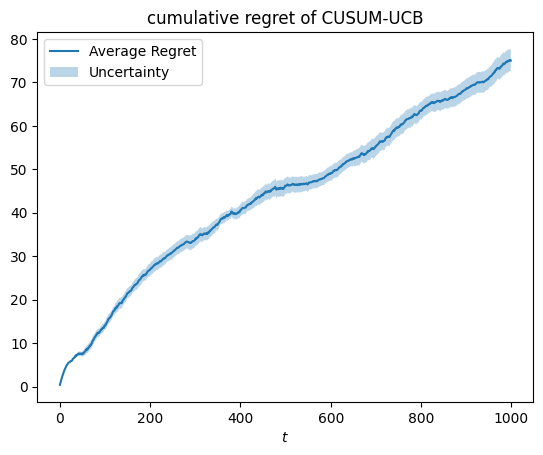

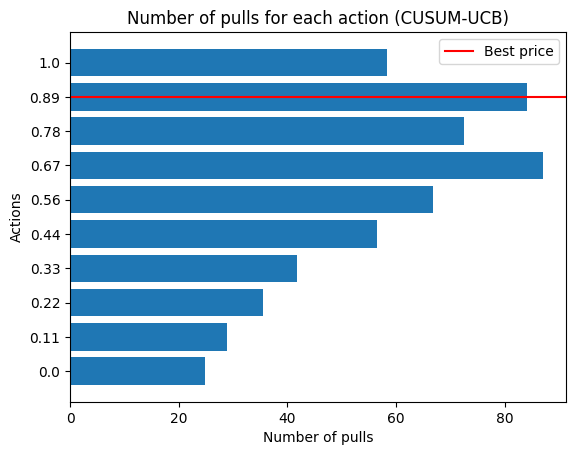

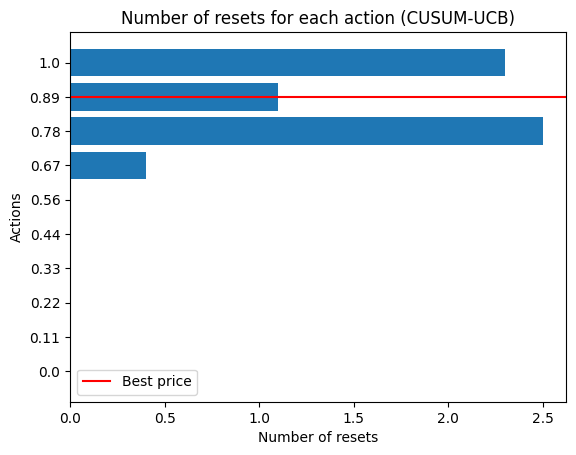

In [22]:
plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of CUSUM-UCB')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()


# Plot del numero di pull per ciascun braccio (bar chart orizzontale)
plt.figure()
plt.barh(np.arange(number_of_prices), average_pulls_cusum, align='center')
plt.axhline(best_price_index, color='red', label='Best price')
plt.yticks(np.arange(number_of_prices), [round(prices[i],2) for i in range(number_of_prices)])
plt.xlabel('Number of pulls')
plt.ylabel('Actions')
plt.title('Number of pulls for each action (CUSUM-UCB)')
plt.legend()
plt.show()



# Plot del numero di reset per ciascun braccio (bar chart orizzontale)
plt.figure()
plt.barh(np.arange(number_of_prices), average_resets_cusum, align='center')
plt.axhline(best_price_index, color='red', label='Best price')
plt.yticks(np.arange(number_of_prices), [round(prices[i],2) for i in range(number_of_prices)])
plt.xlabel('Number of resets')
plt.ylabel('Actions')
plt.title('Number of resets for each action (CUSUM-UCB)')
plt.legend()
plt.show()




We can observe that some arms are not subjected to resets.
We achieve sub-linear regret.